# 第4章　PyTorchを使ったニューラルネット基礎







In [0]:
!pip install torchvision==0.2.1
!pip install pillow==4.2.0

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 519.5MB 37kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59776000 @  0x7f62790a81c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 2.0MB 5.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.8MB 926kB/s 
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0


In [0]:
import torch
torch.__version__

'0.4.1'

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

## CIFAR10をニューラルネットで画像分類

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=False, 
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified


In [3]:
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                          num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=False,
                                         num_workers=2)


In [0]:
num_classes = 10

class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, num_classes)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x= self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet().to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [7]:
#50エポック
num_epochs = 50

#最後に誤差と精度のグラフをプロットするためのリスト
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    #エポックごとに初期化
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train==============================
    #訓練モードへ切り替え
    net.train()
    #ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
      #viewで縦横32ピクセルで3チャンネルの画像を１次元に変換
      #toでgpuに転送
      images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)

      #勾配をリセット
      optimizer.zero_grad()
      #順伝播の計算
      outputs = net(images)
      #誤差の計算
      loss = criterion(outputs, labels)
      #誤差のミニバッチ分を溜め込む
      train_loss += loss.item()
      #精度のミニバッチ分を溜め込む
      #正解ラベル（labels）と予測値のtop1（outputs.max(1)）が合っている場合に1が返ってきます。
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      #逆伝播の計算
      loss.backward()
      #重みの更新
      optimizer.step()
    #平均誤差と平均精度を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val==============================
    #評価モードへ切り替え
    net.eval()
    #評価するときに必要のない計算が走らないようにtorch.no_gradを使用しています。
    with torch.no_grad():
      for images, labels in test_loader:        
        images, labels = images.view(-1, 32*32*3).to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    #訓練データの誤差と検証データの誤差と精度をログで出しています。
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    #最後にグラフをプロットするようにリストに格納
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/50], Loss: 0.0300, val_loss: 0.0277, val_acc: 0.3570
Epoch [2/50], Loss: 0.0273, val_loss: 0.0266, val_acc: 0.4090
Epoch [3/50], Loss: 0.0263, val_loss: 0.0251, val_acc: 0.4270
Epoch [4/50], Loss: 0.0257, val_loss: 0.0243, val_acc: 0.4433
Epoch [5/50], Loss: 0.0251, val_loss: 0.0239, val_acc: 0.4551
Epoch [6/50], Loss: 0.0247, val_loss: 0.0237, val_acc: 0.4673
Epoch [7/50], Loss: 0.0242, val_loss: 0.0232, val_acc: 0.4749
Epoch [8/50], Loss: 0.0239, val_loss: 0.0233, val_acc: 0.4709
Epoch [9/50], Loss: 0.0236, val_loss: 0.0237, val_acc: 0.4533
Epoch [10/50], Loss: 0.0232, val_loss: 0.0232, val_acc: 0.4731
Epoch [11/50], Loss: 0.0230, val_loss: 0.0236, val_acc: 0.4625
Epoch [12/50], Loss: 0.0229, val_loss: 0.0226, val_acc: 0.4764
Epoch [13/50], Loss: 0.0226, val_loss: 0.0229, val_acc: 0.4782
Epoch [14/50], Loss: 0.0225, val_loss: 0.0221, val_acc: 0.5012
Epoch [15/50], Loss: 0.0222, val_loss: 0.0223, val_acc: 0.4901
Epoch [16/50], Loss: 0.0220, val_loss: 0.0222, val_acc: 0.4878
E

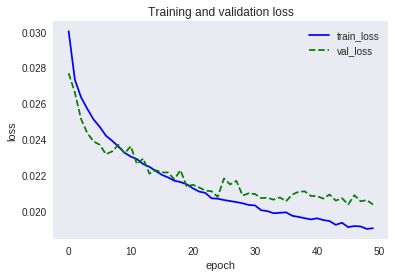

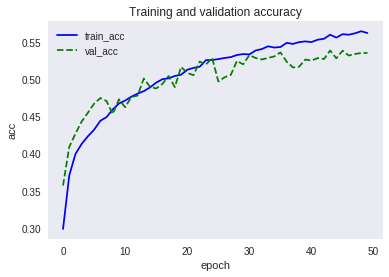

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()